In [1]:
# Execution Environment for KLUE-BERT
# pip install tensorflow==2.10.0
# pip install transformers==4.21.0
# TensorFlow version: 2.10.0
# Transformers version: 4.21.0
import tensorflow as tf
import transformers
print(f"TensorFlow version: {tf.__version__}")
print(f"Transformers version: {transformers.__version__}")

2023-04-26 08:11:45.458844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 08:11:46.422298: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-26 08:11:46.422323: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-26 08:11:46.497908: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-26 08:11:48.499052: W tensorflow/stream_executor/pla

TensorFlow version: 2.10.0
Transformers version: 4.21.0


            labels
count  4827.000000
mean      0.532422
std       0.706620
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       2.000000
   labels                                          sentences
0       0  Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로...
1       0  테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2       2  국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ...
3       1  새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4       1  2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4...
총 샘플의수: 4827
미싱 데이터: 0
중복 데이터: Empty DataFrame
Columns: [labels, sentences]
Index: []
총 샘플의수(중복제거 후): 4827


<AxesSubplot:>

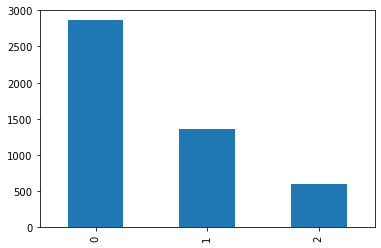

In [2]:
import pandas as pd

# 데이터셋 요약: labels(0/1/2),sentences
dataset = pd.read_csv("dataset_for_cs_summary_classification.csv") # UTF-8 encoding
print(dataset.describe())
print(dataset.head())

# 중복 데이터 확인 및 중복 데이터 제거
print("총 샘플의수:", len(dataset))
print("미싱 데이터:", dataset['labels'].isnull().sum()) # 미싱 검사
print("중복 데이터:", dataset[dataset['sentences'].duplicated()]) # 중복 검사
dataset.drop_duplicates(subset = ['sentences'], inplace = True) # 중복 제거
print("총 샘플의수(중복제거 후):", len(dataset))
dataset['labels'].value_counts().plot(kind = 'bar')

In [4]:
from sklearn.model_selection import train_test_split

# 데이터셋 분리: 학습용 및 검증용
dataset_sentences = dataset['sentences'].tolist()
dataset_labels = dataset['labels'].tolist()

TEST_SIZE = 0.1 # 10% of the dataset
RANDOM_STATE = 1234
train_x, test_x, train_y, test_y = train_test_split(dataset_sentences, dataset_labels, 
                                                    test_size = TEST_SIZE, 
                                                    random_state = RANDOM_STATE, 
                                                    stratify = dataset_labels) # balancing labels(0/1/2)
'''
In the above code, stratify = dataset_labels means that the data will be split in such a way
that the target variable dataset_labels will have the same proportion of classes
in both the training and testing datasets as it has in the original dataset.
This is useful when the dataset is imbalanced,
i.e., one class has significantly fewer samples than the other classes.
'''
print(f"학습용 입력 데이터 개수: {len(train_x)}")
print(f"검증용 입력 데이터 개수: {len(test_x)}")

학습용 입력 데이터 개수: 4344
검증용 입력 데이터 개수: 483


In [5]:
import tensorflow as tf
from transformers import BertTokenizerFast, TFBertForSequenceClassification

# Tokenize the input sentences
tokenizer = BertTokenizerFast.from_pretrained("klue/bert-base")
train_x_tokenized = tokenizer(train_x, truncation=True, padding=True)
test_x_tokenized = tokenizer(test_x, truncation=True, padding=True)

dataset_for_train = tf.data.Dataset.from_tensor_slices((
    dict(train_x_tokenized),
    train_y))

dataset_for_test = tf.data.Dataset.from_tensor_slices((
    dict(test_x_tokenized),
    test_y))

# Train the model
batch_size = 16 # 약 6GB 메모리사용
epochs = 4

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=3, from_pt=True) # labels(0/1/2)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

history = model.fit(dataset_for_train.shuffle(1024).batch(8),
                    validation_data=dataset_for_test.shuffle(1024).batch(8), # 데이터양에 따라 버퍼사이즈 조절필요
                    batch_size=batch_size, epochs=epochs, verbose=1)

# Save the model
model.save_pretrained("output/finetuned-klue-bert-for-cs-summary-classification")
tokenizer.save_pretrained("output/finetuned-klue-bert-for-cs-summary-classification")

2023-04-26 08:55:44.012770: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-26 08:55:44.012815: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-26 08:55:44.012839: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-255-120-161): /proc/driver/nvidia/version does not exist
2023-04-26 08:55:44.013190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
543/543 [==============================] - 1025s 2s/step - loss: 1.5935 - accuracy: 0.5343 - val_loss: 1.0986 - val_accuracy: 0.5921
Epoch 2/4
543/543 [==============================] - 1003s 2s/step - loss: 1.0986 - accuracy: 0.5928 - val_loss: 1.0986 - val_accuracy: 0.5921
Epoch 3/4
543/543 [==============================] - 1002s 2s/step - loss: 1.0986 - accuracy: 0.5928 - val_loss: 1.0986 - val_accuracy: 0.5921
Epoch 4/4
31/31 [==============================] - 20s 659ms/step - loss: 1.0986 - accuracy: 0.5921


('output/finetuned-klue-bert-for-cs-summary-classification/tokenizer_config.json',
 'output/finetuned-klue-bert-for-cs-summary-classification/special_tokens_map.json',
 'output/finetuned-klue-bert-for-cs-summary-classification/vocab.txt',
 'output/finetuned-klue-bert-for-cs-summary-classification/added_tokens.json',
 'output/finetuned-klue-bert-for-cs-summary-classification/tokenizer.json')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


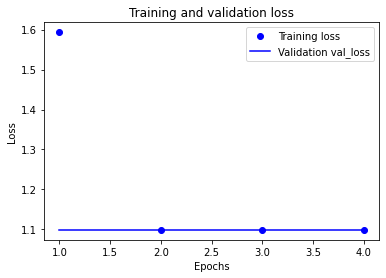

In [7]:
import matplotlib.pyplot as plt

print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# bo = 파란색 점
plt.plot(epochs, loss, 'bo', label='Training loss')
# b = 파란색 실선
plt.plot(epochs, val_loss, 'b', label='Validation val_loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [9]:
# Print the current date and time in the format:
# "YYYY-MM-DD HH:MM:SS.microseconds"
import datetime
def print_current_datetime(text=""):
    datetime_string = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S.%f")
    print("{} @ CDT({})".format(text,datetime_string))

# 모델 및 토크나이저 로딩 및 테스트
import numpy as np
from transformers import BertTokenizerFast
from transformers import TFBertForSequenceClassification
from transformers import TextClassificationPipeline
from timeit import default_timer

print_current_datetime("모델 로딩")

tokenizer_loaded = BertTokenizerFast.from_pretrained("output/finetuned-klue-bert-for-cs-summary-classification")
model_loaded = TFBertForSequenceClassification.from_pretrained("output/finetuned-klue-bert-for-cs-summary-classification")

text_classifier = TextClassificationPipeline(
    tokenizer=tokenizer_loaded, 
    model=model_loaded, 
    framework="tf",
    return_all_scores=True)

print_current_datetime("모델 테스트")

start = default_timer()
predicted_result = text_classifier("왜 타는도중에 꺼지는건지 이해가 안되네요. 걸어가는 사이에도 돈은 다 받아먹네요.")
print(predicted_result)

# 분류예측 결과로부터 라벨이름 맵핑
label_map = {0: "Neutral", 1: "Positive", 2: "Negative"}

predicted_label_scores = []
for prediction_item in predicted_result:
    for prediction_dict in prediction_item:
        predicted_label_scores.append(prediction_dict["score"])
    predicted_label_id = np.argmax(predicted_label_scores)
    predicted_label_name = label_map[predicted_label_id]
print(predicted_label_name)

end = default_timer()
print("Time duration(in seconds):", end - start)

모델 로딩 @ CDT(2023-04-26T10:03:25.537688)


Some layers from the model checkpoint at output/finetuned-klue-bert-for-cs-summary-classification were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at output/finetuned-klue-bert-for-cs-summary-classification.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further trainin

모델 테스트 @ CDT(2023-04-26T10:03:27.248538)
[[{'label': 'LABEL_0', 'score': 0.5116426348686218}, {'label': 'LABEL_1', 'score': 0.2741449177265167}, {'label': 'LABEL_2', 'score': 0.21421246230602264}]]
Neutral
Time duration(in seconds): 0.20727669401094317
